# Music Genre Classification

Final project of course: **Foundation of data science** - prof. Fabio Galasso, a.y. 2020-2021 

Authors: *Chiara Chiucchi* 1645894, *Andrea Trianni*  1806198, *Emanuele Mercanti*  1719869, *Matteo Pascolini*  1693444 

____________________________________________________________________________________________________________


## 1. Understanding Audio Data
 

### 1.1 Fourier Transform

Let's take for example one of the track from our dataset.


In [ ]:
# import module

import os
from os import listdir
import librosa, librosa.display
import math
import json
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import tensorflow.keras as keras
from keras import backend as K
from keras.constraints import Constraint
# import youtube_dl
# from pydub import AudioSegment
import seaborn as sns


In [ ]:
# !pip install scikit-plot
import scikitplot as skplt


In [ ]:
# path module

%cd /content/drive/My Drive/FDS/
CURRENT_DIR = os.path.abspath(os.getcwd())
# GTZAN_DATASET_PATH = os.path.join(os.path.join(CURRENT_DIR, "GTZAN_Dataset"), "genres_original")
# PERSONAL_DATASET_PATH = os.path.join(CURRENT_DIR, "PERSONAL_Dataset")
# GTZAN_DATASET_CLEAN_PATH = os.path.join(os.path.join(CURRENT_DIR, "GTZAN_Dataset_Clean"), "genres_original")

GTZAN_JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "Data"), "GTZAN_Dataset.json")
GTZAN_CLEAN_JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "Data"), "GTZAN_Dataset_Clean.json")
PERSONAL_JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "Data"), "PERSONAL_Dataset.json")


# SAMPLE_PATH = os.path.join(os.path.join(GTZAN_DATASET_PATH,"blues"), "blues.00000.wav")

/content/drive/My Drive/FDS


In [ ]:
def plot_waveform(file):
    # signal: numpy array with # values = sr * T -> 22050 * 30 seconds
    signal, sr = librosa.load(file, sr=22050) # standard sample rate
    librosa.display.waveplot(signal, sr=sr)
    
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show() 
    
    return signal, sr

And let's plot its **waveform**.

In [ ]:
signal, sr = plot_waveform(SAMPLE_PATH)

Applying a Fourier Transform we obtain a **Power Spectrum** that gives as the magnitude (power) as a function of the frequency. Let's consider previous samples:

In [ ]:
def plot_FFT(signal, sr):
    fft = np.fft.fft(signal)
    
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))
    
    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]
    
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show() 

And let's plot is **Fast Fourier Transform**:

In [ ]:
plot_FFT(signal, sr)

### 1.2 Short Time Fourier Transform (STFT)

Gives us a **spectrogram** which represents the magnitude as a function of both frequency and time. 

In [ ]:
def plot_STFT(signal, sr):
    n_fft = 2048
    hop_length = 512 # amount we are shifting each FFT to the right
    
    stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(stft)
    # for visualization purpose (to decibel)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)    
    
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    plt.show()
    
    return n_fft, hop_length
    

In [ ]:
n_fft, hop_length = plot_STFT(signal, sr)

There exists another feature that is more important and detailed than STFT.

### 1.3 Mel Frequency Cepstral Coefficients (MFCCs)

 MFCC is a vector of **coefficients**: usually in audio application the number varies from 13 to 40 coefficients. These coefficients are calculated at each frame, so that we can have an idea of how MFCCs evolve over time. 

In [ ]:
def plot_MFCCs(signal, n_fft, hop_length):
    MFCCs = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC")
    plt.colorbar()
    plt.show()

In [ ]:
plot_MFCCs(signal, n_fft, hop_length)

_________________________________________________________________________________________________________________

## 2. Preparing the Datasets

### 2.1  Building our  personal dataset

Now, let's build our dataset to train the networks and create the models. Indeed, in addition to the GTZAN dataset for music classification, we will try to collect data ourselves, and then going to perform the entire data preprocessing phase, analyzing the dataset and balancing it.

Our approach to data collection is to create a playlist on youtube for each genre considered. Then a formatted text file is created, which collects all the web links to the video resources. This file is therefore like a small database that is used by the code script to find the necessary data.


### 2.1.1 Retrieve the raw data

Each song is downloaded in video format, then converted to audio format. The latter has a fixed length which is decided by a hyper-parameter of the script; the fragment is taken from the center of the initial length.
To perform this conversion you need to install * ffmpeg * and set the environment variables, for more details refer to the official website. The following statements can also be written that the command:

"ffmpeg -i path_to_video -acodec pcm_s16le -ac 1 -ar 22050 -vn new_filename+".wav"

In [ ]:
DATABASE_FILENAME = "link_database.txt" 
DURATION = 30 

In [ ]:
# !! ATTENTION : executing this part can take a long time, and you don't need to do it.

# Open the txt file with the links
with open(os.path.join(PERSONAL_DATASET_PATH, DATABASE_FILENAME)) as f:
    lines = f.read().splitlines()

# For stats and plot only
length = []
sizes = {}

for line in lines:
    
    genre, link = line.split(" *** ")
    genre_path = PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+ genre
    ydl_opts = {'outtmpl': genre_path + '/%(autonumber)s.%(ext)s', 'format': 'bestaudio/worstvideo','quiet': True}
    
    # Download playlist for each genre
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        
        print("Downloading song of genre: "+genre)
        ydl.download([link])
        videos = [f for f in listdir(genre_path)]
        sizes[genre] = len(videos)
        
        # Convert in audio, cut the lenght, and compress
        for video in videos:
            
            audio = AudioSegment.from_file(genre_path + "/" + video)
            length += [len(audio)//1000]
            
            if len(audio) > DURATION*1000:
                half = len(audio)//2
                audio = audio[half-(DURATION*500) : half+(DURATION*500)]
                audio.export( genre_path + "/" + video.split(".")[0] + ".wav", format="wav", parameters=["-ac", "1", "-ar", "22050", "-acodec", "pcm_s16le"])
            
            os.remove(genre_path+"/"+video)

# Store the stats for future plots
with open(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+str(DURATION)+"_plotinfo.json", "w") as fp:
    json.dump({"length": length, "sizes": sizes}, fp)


### 2.1.2 Visualize the collected data

Visualizing the collected data is very important, so we will now show two very important plots: the first concerns the size of the classes, the second the duration of the songs.

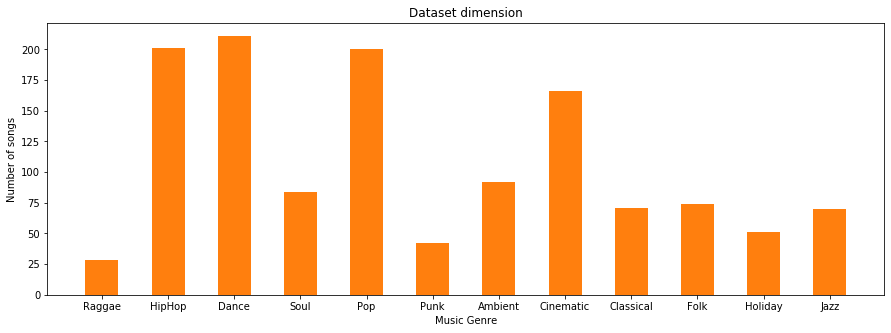

<Figure size 432x288 with 0 Axes>

In [ ]:
def size_bar_plot (classes,sizes):
    for genre in classes:
        plt.bar(classes, sizes, 0.50)

    plt.gcf().set_size_inches(15,5)
    plt.ylabel("Number of songs")
    plt.xlabel("Music Genre")
    plt.title("Dataset dimension")

    plt.show()
    plt.cla(); plt.clf();


with open(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+str(DURATION)+"_plotinfo.json", "r") as fp:
    content = json.load(fp)

size_bar_plot (content["sizes"].keys(),content["sizes"].values())

c:\users\chiar\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


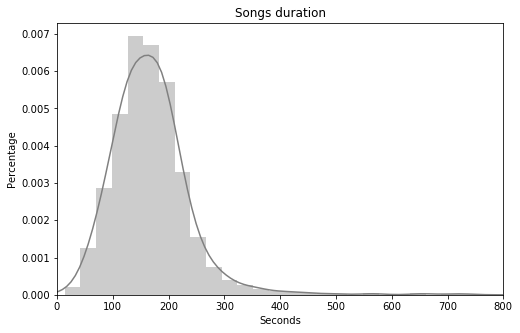

<Figure size 432x288 with 0 Axes>

In [ ]:
with open(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+str(DURATION)+"_plotinfo.json", "r") as fp:
    content = json.load(fp)
    
plt.gcf().set_size_inches(8,5)
sns.distplot(content["length"], color="grey")
plt.xlim([0, 800]);
plt.xlabel('Seconds')
plt.ylabel('Percentage')
plt.title("Songs duration")
plt.show()
plt.cla(); plt.clf();

### 2.1.3 Balancing the dataset : remove tiny classes

For of all we delete the classes that are less representative.

In [ ]:
# elimino le classi troppo scarse

with open(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+str(DURATION)+"_plotinfo.json", "r") as fp:
    content = json.load(fp)

if len(content["sizes"].items()) > 10:
    rem_ordered = sorted(content["sizes"].items(), key=lambda x: x[1])
    rem_ordered = [i[0] for i in rem_ordered][:2]
    for rem in rem_ordered:
        for file in listdir(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+rem):
            os.remove(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+rem+"/"+file)
        os.rmdir(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+rem)

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: 'C:\\Users\\chiar\\Desktop\\FDS_PROG\\PERSONAL_Dataset/30/Raggae'

### 2.1.4 Balancing the dataset : undersampling huge classes

In [ ]:
CLASS_MAX_SIZE=100;

genres = next(os.walk(PERSONAL_DATASET_PATH+"/"+str(DURATION)))[1]

for genre in genres:
    genre_path = PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+genre
    print("Processing: "+ genre_path)
    count=0
    for song in listdir(genre_path):
        if count>=100: 
            os.remove(genre_path+"/"+song)
        count+=1

sizes   = [len(listdir(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+genre)) for genre in genres]
size_bar_plot (genres,sizes)

Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Ambient
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Cinematic
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Classical
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Dance
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Folk
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/HipHop
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Holiday
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Jazz
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Pop
Processing: C:\Users\chiar\Desktop\FDS_PROG\PERSONAL_Dataset/30/Soul


NameError: name 'size_bar_plot' is not defined

### 2.1.5 Balancing the dataset : use weighted loss


In [ ]:
genres = next(os.walk(PERSONAL_DATASET_PATH+"/"+str(DURATION)))[1]
sizes   = [len(listdir(PERSONAL_DATASET_PATH+"/"+str(DURATION)+"/"+genre)) for genre in genres]
total_count = sum (sizes)
class_weights= {}

key=0
for size in sizes:
    class_weights[key] = (1 / size) * (total_count) / 10.0
    key+=1

print(class_weights)

{0: 0.9119565217391304, 1: 0.8390000000000001, 2: 1.2159420289855072, 3: 0.8390000000000001, 4: 1.1493150684931508, 5: 0.8390000000000001, 6: 1.6450980392156862, 7: 1.1985714285714286, 8: 0.8390000000000001, 9: 0.9988095238095237}


### 2.2 The GTZAN Dataset

Scrivere qualche parola qui ...

### 2.3 Use the datasets

Now there is the part of the code that reads the data from the hard disk and prepares it for the model.

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store data
    data = {
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # loop through all the genres

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure that we're not at the root level
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_components = dirpath.split("\\")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for file in filenames:
                # load audio file
                file_path = os.path.join(dirpath, file)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft = n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)

                except Exception as ex:
                    print("An error occurred")
                    pass

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)



In [ ]:
# save_mfcc(GTZAN_DATASET_PATH, GTZAN_JSON_PATH, num_segments=10)
save_mfcc(GTZAN_DATASET_CLEAN_PATH, GTZAN_CLEAN_JSON_PATH, num_segments=10)
# save_mfcc(PERSONAL_DATASET_PATH+"/"+str(DURATION), PERSONAL_JSON_PATH, num_segments=10)

In [ ]:
# load data
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    genres = np.array(data["mapping"])

    return inputs, targets, genres

In [ ]:
# plot accuracy and error over the epochs

def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="Train Error")
    axs[1].plot(history.history["val_loss"], label="Test Error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    # axs[1].set_title("Error Eval")

    plt.show()

In [ ]:
# create train, validation and test sets
def prepare_datasets(X, y, test_size, validation_size):
    # create train/test split
    X_validation, y_validation = [], []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if validation_size > 0:
        # create train/validation split
        X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_validation, X_test, y_train, y_validation, y_test   

### 2.4. Loading Dataset

In [ ]:
X, y, c = load_data(GTZAN_JSON_PATH)

In [ ]:
clean_X, clean_y, clean_c = load_data(GTZAN_CLEAN_JSON_PATH)

In [ ]:
our_X, our_y, our_c = load_data(PERSONAL_JSON_PATH)

_______________________________________________________________________

# 3. Implementing a Neural Network for Genre Classification

## 3.1 Feed-forward architecture

In [ ]:
class Custom_constraint(Constraint):
    def __init__(self, good_weights):
        self.good_weights = K.cast_to_floatx(good_weights)  
    def __call__(self, w):
        return self.good_weights * w  
    def get_config(self):
        return {'good_weights': self.good_weights}


def keep_good_weights(model, sparsity = 30):
    weights = model.get_weights()
    good_weights = []
    for weight in weights:
        if len(weight.shape) > 1:
            weight = np.abs(weight)
            good_weights.append( weight > np.percentile(weight, sparsity) )
    return good_weights




def build_initial_MLP(inputs):
    model = keras.Sequential([                          
                  keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
                  keras.layers.Dense(units = 500, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense( units = 400, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 300, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 200, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="elu",
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),    

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 
  


def build_sparse_MLP(inputs, sparse_weights):
    model = keras.Sequential([                          
                  keras.layers.Flatten( input_shape=(inputs.shape[1], inputs.shape[2])),

                  keras.layers.Dense(units = 500, 
                                    activation = "elu", 
                                    kernel_regularizer = keras.regularizers.l2(0.01),
                                    kernel_constraint = Custom_constraint(sparse_weights[0]) 
                                    ),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense( units = 400, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Custom_constraint(sparse_weights[1])
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 300, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Custom_constraint(sparse_weights[2])
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 200, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Custom_constraint(sparse_weights[3])
                                    ),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="elu",
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Custom_constraint(sparse_weights[4]) 
                                    ),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 


def build(inputs):
    model = keras.Sequential([                          
                  keras.layers.Flatten( input_shape=(inputs.shape[1], inputs.shape[2])),

                  keras.layers.Dense(units = 500, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense(units = 400, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 300, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 200, 
                                    activation="elu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="elu",
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 



In [ ]:
def compile_MLP(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

def compile_model(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])


In [ ]:
def initial_dense_multi_layer_perceptron(X, y):

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0.2)
    model = build_initial_MLP(X_train)
    compile_MLP(model)
    history = train(model, X_train, X_validation, y_train, y_validation)
    return model


def sparse_multi_layer_perceptron(X, y, prev_model):

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0.2)
    sparse_model = build_sparse_MLP(X_train, keep_good_weights(prev_model))
    compile_MLP(sparse_model)
    sparse_model.set_weights(prev_model.get_weights())
    history = train(sparse_model, X_train, X_validation, y_train, y_validation)    
    return sparse_model

In [ ]:
def train(model, X_train, X_validation, y_train, y_validation):
    if len(X_validation) > 0:
        callback = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10, mode='auto')
        history = model.fit(X_train, y_train, validation_data= (X_validation, y_validation), batch_size=32, epochs=200, callbacks=[callback])
    else: 
        callback = keras.callbacks.EarlyStopping(monitor='loss',  patience=10, mode='auto')
        history = model.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=[callback])
    return history

In [ ]:
def test(model, X_test, y_test):
    # here verbose was = 2
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    return test_loss, test_accuracy


def get_classification_report(model, X, y):
    prediction = np.argmax(model.predict(X), axis=1)
    return classification_report(y_true = y, y_pred = prediction)

In [ ]:
# k-fold cross-validation
def k_fold_cross_validation(X, y, n_split, network, cw = np.ones(10)):
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0)
    kfold = KFold(n_splits=n_split, shuffle=True)
    if network == "nn":
        input_shape = X_train
    elif network == "cnn":
        input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    else:
        input_shape = (X_train.shape[1], X_train.shape[2])
    acc_per_fold = []
    loss_per_fold = []
    fold_no = 1
    
    for tr, ts in kfold.split(X_train, y_train):
        model = build(input_shape)
        compile_model(model, cw)
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        history = train(model, X[tr], X_validation, y[tr], y_validation)
        scores = test(model, X[ts], y[ts])
        
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')   

In [ ]:
def get_confusion_matrix(X_test, y_target, classes):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_target, y_pred)
    df_cm = pandas.DataFrame(cm,index=classes, columns=classes)
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="gray",linewidths=.5)

    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
    plt.ylabel('Target Genre')
    plt.xlabel('Predicted Genre')
    plt.title("Test Confusion Matrix")

    plt.show()
    plt.cla()
    plt.clf()

In [ ]:
def plot_roc(model, X, y):
    y_score = model.predict_proba(X)
    skplt.metrics.plot_roc(y, y_score)
    plt.show()

### 3.1.1. Training/Testing on GTZAN dataset

In [ ]:
k_fold_cross_validation(X, y, 2, "nn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0.2)

In [ ]:
# 1st dense model
initial_dense_model = initial_dense_multi_layer_perceptron(X, y)

# sparse model
sparse_model = sparse_multi_layer_perceptron(X, y, initial_dense_model)

In [ ]:
model = build(X_train)
compile_model(model)
model.set_weights(sparse_model.get_weights())

In [ ]:
history = train(model, X_train, X_validation, y_train, y_validation)

Epoch 1/200
188/188 [==============================] - 4s 19ms/step - loss: 0.9558 - accuracy: 0.8764 - val_loss: 0.8477 - val_accuracy: 0.9166
Epoch 2/200
188/188 [==============================] - 3s 17ms/step - loss: 0.8625 - accuracy: 0.9066 - val_loss: 0.8358 - val_accuracy: 0.9152
Epoch 3/200
188/188 [==============================] - 3s 18ms/step - loss: 0.8367 - accuracy: 0.9192 - val_loss: 0.8329 - val_accuracy: 0.9186
Epoch 4/200
188/188 [==============================] - 3s 17ms/step - loss: 0.8156 - accuracy: 0.9178 - val_loss: 0.8248 - val_accuracy: 0.9172
Epoch 5/200
188/188 [==============================] - 3s 18ms/step - loss: 0.8078 - accuracy: 0.9174 - val_loss: 0.8196 - val_accuracy: 0.9186
Epoch 6/200
188/188 [==============================] - 3s 17ms/step - loss: 0.7873 - accuracy: 0.9292 - val_loss: 0.8197 - val_accuracy: 0.9146
Epoch 7/200
188/188 [==============================] - 3s 17ms/step - loss: 0.7951 - accuracy: 0.9212 - val_loss: 0.8190 - val_accuracy:

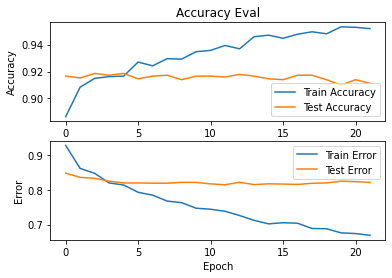

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_accuracy = test(model, X_test, y_test)  
report = get_classification_report(model, X_test, y_test) 

79/79 [==============================] - 0s 6ms/step - loss: 0.7882 - accuracy: 0.9171


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


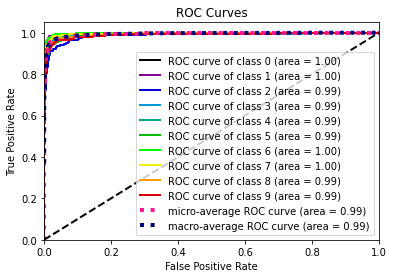

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

Accuracy on test set is: 0.9171005487442017
Loss on test set is: 0.7882264256477356
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       235
           1       0.96      0.94      0.95       256
           2       0.88      0.85      0.86       244
           3       0.94      0.92      0.93       259
           4       0.90      0.94      0.92       236
           5       0.87      0.92      0.89       259
           6       0.96      0.94      0.95       251
           7       0.93      0.94      0.94       259
           8       0.93      0.92      0.92       254
           9       0.87      0.91      0.89       244

    accuracy                           0.92      2497
   macro avg       0.92      0.92      0.92      2497
weighted avg       0.92      0.92      0.92      2497



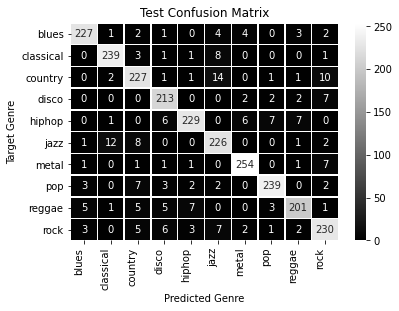

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix(X_test, y_test, c)

### 3.1.2. Training/Testing on clean GTZAN

In [ ]:
k_fold_cross_validation(clean_X, clean_y, 2, "nn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(clean_X, clean_y, 0.25, 0.2)

In [ ]:
# 1st dense model
initial_dense_model = initial_dense_multi_layer_perceptron(clean_X, clean_y)

# sparse model
sparse_model = sparse_multi_layer_perceptron(clean_X, clean_y, initial_dense_model)

In [ ]:
model = build(X_train)
compile_model(model)
model.set_weights(sparse_model.get_weights())

In [ ]:
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_accuracy = test(model, X_test, y_test)   
report = get_classification_report(model, X_test, y_test) 

73/73 [==============================] - 0s 6ms/step - loss: 0.7916 - accuracy: 0.9512


In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

Accuracy on test set is: 0.9512300491333008
Loss on test set is: 0.7915685176849365
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       248
           1       0.97      0.97      0.97       249
           2       0.92      0.95      0.93       256
           3       0.96      0.96      0.96       232
           4       0.98      0.93      0.95       233
           5       0.91      0.94      0.93       200
           6       0.97      0.98      0.97       229
           7       0.96      0.96      0.96       227
           8       0.96      0.94      0.95       211
           9       0.92      0.91      0.91       232

    accuracy                           0.95      2317
   macro avg       0.95      0.95      0.95      2317
weighted avg       0.95      0.95      0.95      2317



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


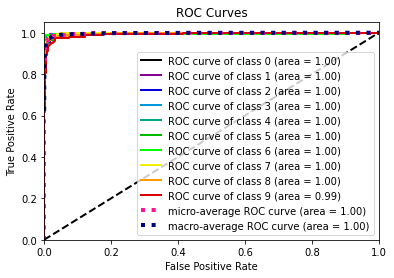

In [ ]:
plot_roc(model, X_test, y_test)

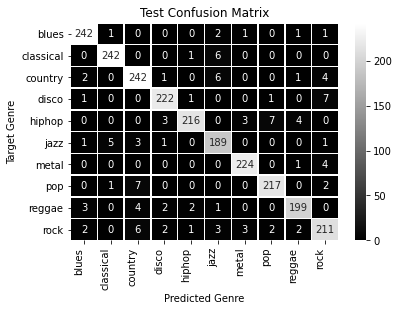

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix(X_test, y_test, clean_c)

### 3.1.3. Training/Testing on our dataset

In [ ]:
k_fold_cross_validation(our_X, our_y, 2, "nn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(our_X, our_y, 0.25, 0.2)

In [ ]:
# 1st dense model
initial_dense_model = initial_dense_multi_layer_perceptron(our_X, our_y)

# sparse model
sparse_model = sparse_multi_layer_perceptron(our_X, our_y, initial_dense_model)

In [ ]:
model = build(X_train)
compile_model(model)
model.set_weights(sparse_model.get_weights())

In [ ]:
history = train(model, X_train, X_validation, y_train, y_validation)

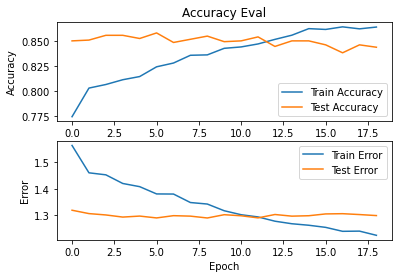

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_accuracy = test(model, X_test, y_test)   
report = get_classification_report(model, X_test, y_test) 

66/66 [==============================] - 0s 6ms/step - loss: 1.3033 - accuracy: 0.8584


In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

Accuracy on test set is: 0.8584365844726562
Loss on test set is: 1.3032809495925903
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       200
           1       0.73      0.85      0.78       242
           2       0.81      0.79      0.80       180
           3       0.89      0.86      0.87       252
           4       0.92      0.90      0.91       183
           5       0.94      0.90      0.92       274
           6       0.77      0.82      0.80       102
           7       0.90      0.87      0.88       197
           8       0.90      0.90      0.90       250
           9       0.93      0.85      0.89       218

    accuracy                           0.86      2098
   macro avg       0.86      0.85      0.85      2098
weighted avg       0.86      0.86      0.86      2098



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


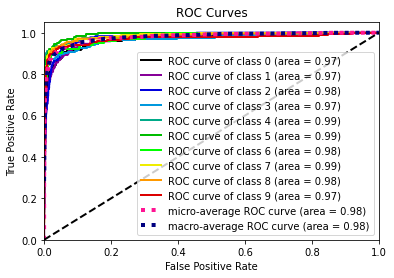

In [ ]:
plot_roc(model, X_test, y_test)

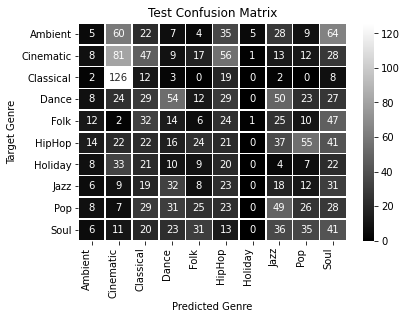

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix(X_test, y_test, our_c)

## 3.2 Convolutional Neural Network

In [ ]:
# build the CNN network
def build(input_shape):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

### 3.2.1 Training/Testing on GTZAN dataset

In [ ]:
inputs = X[..., np.newaxis]

In [ ]:
k_fold_cross_validation(inputs, y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(inputs, y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)


In [ ]:
# test CNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
# classification report
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, c)

### 3.2.2. Training/Testing on clean GTZAN

In [ ]:
clean_inputs = clean_X[..., np.newaxis]

In [ ]:
k_fold_cross_validation(clean_inputs, clean_y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(clean_inputs, clean_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
# classification report
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, clean_c)

### 3.2.3 Training/Testing on our dataset

In [ ]:
our_inputs = our_X[..., np.newaxis]

In [ ]:
k_fold_cross_validation(our_inputs, our_y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(our_inputs, our_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
# classification report
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, our_c)

# 3.3 Recurrent Neural Network

In [ ]:
# build the RNN network
def build(input_shape):
    # create model
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

### 3.3.1 Training/Testing on GTZAN dataset

In [ ]:
k_fold_cross_validation(X, y, 2, "rnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, c)

### 3.3.2 Training/Testing on clean GTZAN

In [ ]:
k_fold_cross_validation(clean_X, clean_y, 2, "rnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(clean_X, clean_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, clean_c)

### 3.3.3 Training/Testing on our dataset

In [ ]:
k_fold_cross_validation(our_X, our_y, 2, "rnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(our_X, our_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
# build the network
model = build(input_shape)

# compile the network
compile_model(model)

In [ ]:
# train CNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, our_c)

# 3.4. Convolutional Recurrent Neural Network

In [ ]:
def build(input_shape):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(64, (3,3), activation='elu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='same')) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.1))
                                
    model.add(keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(4, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(4, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(4, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.1))
    
    last_layer = model.layers[-1]
    output_shape = last_layer.output_shape
    model.add(keras.layers.Reshape((int(output_shape[1]), int(output_shape[2] * output_shape[3]))))
    
    model.add(keras.layers.Dense(32, activation='elu'))
    model.add(keras.layers.GRU(32, dropout=0.3,return_sequences=True))
    model.add(keras.layers.GRU(32, dropout=0.3,return_sequences=True))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model


### 3.4.1 Training/Testing on GTZAN dataset

In [ ]:
k_fold_cross_validation(inputs, y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(inputs, y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the CRNN
model = build(input_shape)
    
# compile the network
compile_model(model)

In [ ]:
# train CRNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, c)

### 3.4.2 Training/Testing on clean GTZAN

In [ ]:
k_fold_cross_validation(clean_inputs, clean_y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(clean_inputs, clean_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the CRNN
model = build(input_shape)
    
# compile the network
compile_model(model)

In [ ]:
# train CRNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CRNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, clean_c)

### 3.4.3 Training/Testing on our dataset

In [ ]:
k_fold_cross_validation(our_inputs, our_y, 2, "cnn")

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(our_inputs, our_y, 0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [ ]:
# build the CRNN
model = build(input_shape)
    
# compile the network
compile_model(model)

In [ ]:
# train CRNN
history = train(model, X_train, X_validation, y_train, y_validation)

In [ ]:
plot_history(history)

In [ ]:
# test CRNN on test set
test_loss, test_accuracy = test(model, X_test, y_test)
    
report = get_classification_report(model, X_test, y_test)

In [ ]:
print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print(report)

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
get_confusion_matrix(X_test, y_test, our_c)